Imports

In [56]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt


Load Datasets

In [57]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(train_df.shape)
print(test_df.shape)
train_df.head()

(5520, 5)
(2000, 5)


,headlines,description,content,url,category
0,RBI revises definition of politically-exposed ...,The central bank has also asked chairpersons a...,The Reserve Bank of India (RBI) has changed th...,https://indianexpress.com/article/business/ban...,business
1,NDTV Q2 net profit falls 57.4% to Rs 5.55 cror...,NDTV's consolidated revenue from operations wa...,Broadcaster New Delhi Television Ltd on Monday...,https://indianexpress.com/article/business/com...,business
2,"Akasa Air ‘well capitalised’, can grow much fa...",The initial share sale will be open for public...,Homegrown server maker Netweb Technologies Ind...,https://indianexpress.com/article/business/mar...,business
3,India’s current account deficit declines sharp...,The current account deficit (CAD) was 3.8 per ...,India’s current account deficit declined sharp...,https://indianexpress.com/article/business/eco...,business
4,"States borrowing cost soars to 7.68%, highest ...",The prices shot up reflecting the overall high...,States have been forced to pay through their n...,https://indianexpress.com/article/business/eco...,business


NLTK data

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Millpark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Millpark\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text Preprocessing

In [5]:
def clean_text(text):
    if pd.isna(text):
        return ''
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

Clean data

In [6]:
train_df.columns = train_df.columns.str.strip().str.lower()
test_df.columns = test_df.columns.str.strip().str.lower()

In [7]:
def combine_text_columns(df):
    df['combined_text'] = (
        df['headlines'].fillna('') + ' ' +
        df['description'].fillna('') + ' ' +
        df['content'].fillna('')
    )
    return df

train_df = combine_text_columns(train_df)
test_df = combine_text_columns(test_df)

Clean text

In [8]:
train_df['clean_text'] = train_df['combined_text'].apply(clean_text)
test_df['clean_text'] = test_df['combined_text'].apply(clean_text)

Split train and test

In [9]:
X = train_df['clean_text']
y = train_df['category']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Vectorization

In [59]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

Models

In [43]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC(),
    "Multinomial NB": MultinomialNB(),
    "CatBoost": CatBoostClassifier(verbose=0, iterations=200, learning_rate=0.1, depth=6)
}


Model Training

In [44]:
results = []

for name, model in models.items():
    print("="*60)
    print(f"Training Model: {name}")
    print("="*60)
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_val_tfidf)
    
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, average='weighted', zero_division=0)
    rec = recall_score(y_val, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_val, preds, average='weighted', zero_division=0)
    
    results.append([name, acc, prec, rec, f1])
    
    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

Training Model: Logistic Regression

Accuracy: 0.9864
Precision: 0.9865
Recall: 0.9864
F1 Score: 0.9864
Training Model: Random Forest

Accuracy: 0.9728
Precision: 0.9733
Recall: 0.9728
F1 Score: 0.9729
Training Model: Linear SVM

Accuracy: 0.9873
Precision: 0.9873
Recall: 0.9873
F1 Score: 0.9873
Training Model: Multinomial NB

Accuracy: 0.9837
Precision: 0.9837
Recall: 0.9837
F1 Score: 0.9837
Training Model: CatBoost

Accuracy: 0.9755
Precision: 0.9758
Recall: 0.9755
F1 Score: 0.9756


Confusion Matrix


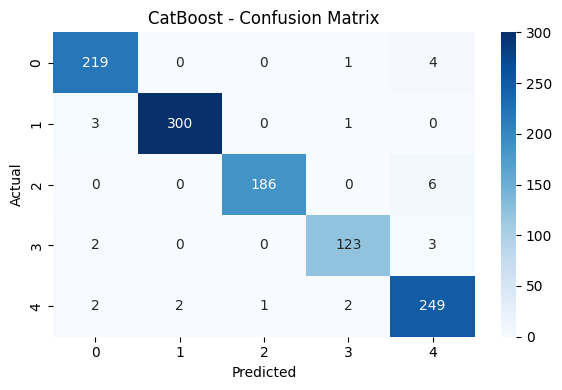

In [45]:
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_val, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show(block=True)  

C:\Users\Millpark\AppData\Local\Temp\ipykernel_45684\3358351403.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


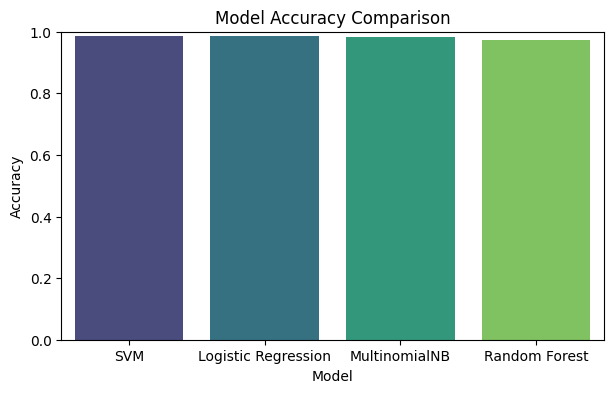

In [46]:
plt.figure(figsize=(7, 4))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [47]:
print("Length of results:", len(results))
print("Results list content:", results)

Length of results: 5
Results list content: [['Logistic Regression', 0.9864130434782609, 0.9864648004559292, 0.9864130434782609, 0.9864084624434135], ['Random Forest', 0.9728260869565217, 0.973299596056421, 0.9728260869565217, 0.9728889537385017], ['Linear SVM', 0.9873188405797102, 0.9873286806593476, 0.9873188405797102, 0.987306597818665], ['Multinomial NB', 0.9836956521739131, 0.9837419693699095, 0.9836956521739131, 0.9836681079928421], ['CatBoost', 0.9755434782608695, 0.9758045088426628, 0.9755434782608695, 0.9756057740861358]]


In [50]:
import joblib

# Best model name (ensure proper matching)
best_model_name = "Linear SVM"   # since that's the actual key in models dict
best_model = models[best_model_name]





In [61]:
# Save model and vectorizer separately
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC   # change to best model
import joblib

# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Combine text
train_df['text'] = train_df['headlines'].astype(str) + " " + train_df['description'].astype(str)
test_df['text'] = test_df['headlines'].astype(str) + " " + test_df['description'].astype(str)

X_train, y_train = train_df['text'], train_df['category']
X_val, y_val = test_df['text'], test_df['category']

# Build pipeline with TF-IDF + classifier
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("clf", LinearSVC())   # 👈 replace with your best model if different
])

# Train on train.csv
pipeline.fit(X_train, y_train)

# Evaluate on test.csv
print("Validation Accuracy:", pipeline.score(X_val, y_val))

# Save pipeline (single file)
joblib.dump(pipeline, "news_classifier.pkl")
print("💾 Saved as news_classifier.pkl")

Validation Accuracy: 0.951
💾 Saved as news_classifier.pkl


In [65]:
# Save separately
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(best_model, "best_model.pkl")

# Load separately
tfidf = joblib.load("tfidf_vectorizer.pkl")
best_model = joblib.load("best_model.pkl")

# Transform new text using TF-IDF, then predict
new_text = ["Cristiano Ronaldo scores twice in Champions League match"]
X_new = tfidf.transform(new_text)
print(best_model.predict(X_new))

['sports']


In [63]:
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

Summary

In [39]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
results_df = results_df.sort_values(by='F1-Score', ascending=False)
print("\n\n=========== MODEL COMPARISON SUMMARY ===========\n")
print(results_df)



=========== MODEL COMPARISON SUMMARY ===========

                 Model  Accuracy  Precision    Recall  F1-Score
3                  SVM  0.987319   0.987329  0.987319  0.987307
1  Logistic Regression  0.986413   0.986465  0.986413  0.986408
0        MultinomialNB  0.983696   0.983742  0.983696  0.983668
2        Random Forest  0.972826   0.973300  0.972826  0.972889


STREAMLIT

In [68]:
pipeline = joblib.load("news_classifier.pkl")
prediction = pipeline.predict([user_input])[0]